# PS 2 metrics cooper

parameters to estimate beta, gamma, theta, mu_a, sigma_a and rho_a; we assume to know alpha & delta; <br>
$\implies k*_{t+1}(k_t,A_t)$, simulate A and k and loop through value function iteration; <br> Tauchen and AR(1) to get A grid; <br>
Given optimal output calculate cons, employ, output and interest rate <br>
To set up right grid around K_ss: Put in minimum and maximum of a_grid in FOC and LinRange around <br>

no need to loop over theta $\implies$ back it up from labour FOC; <br>

loop over beta and gamma as input parameters;

moments: 8 parameters from regression and var-covar matrix (3 elements)

---
Some derivation before we start: Try to find FOC's for labour and capital <br>



In [4]:
using LaTeXStrings, LinearAlgebra, Plots, Distributions, StatsBase, Random, Statistics, GLM, DataFrames

In [56]:
c = cons(z_grid[1], k_grid[1], k_grid)

#maximum(c,0.01)

100-element LinRange{Float64, Int64}:
 0.62572,0.621536,0.617352,0.613168,…,0.224055,0.219871,0.215687,0.211503

In [42]:
# production function
function prod(A, k, alpha=alpha)
    return A*(k^(1-alpha))
end

# consumption function
function cons(A, k, k_next, alpha=alpha, delta=delta)
    return prod(A, k) + k*(1-delta) .- k_next
end

# utility function
function util(c, gamma=gamma, alpha=alpha, delta=delta, theta=theta)
    for i in 1:length(c)
        c_now = c[i]
        if c_now <= 0
            c[i] = 1e-100
        end
    end
    return (c.^(1-gamma) .- 1)./(1-gamma)
end

util (generic function with 5 methods)

In [7]:
# Implement Tauchen

function Tauchen(nz, rho, sigma, mu, q=2)
    
    """
       Implementation of the discretization method for an continuous process as proposed by Tauchen (1986).
       Takes the number number different states, sigma and rho (relevant estimates of the AR(1) process)
       as inputs. The last input, q, is the number of standard deviations associated with the grid range.
       Outputs are the grid (z_grid) and the transition matrix (pi).
    """
    
    pi = zeros(nz,nz) # storage
    uncond_sd = sqrt(sigma^2/(1-rho^2)) #calculate unconditional std. dev.
    z_grid = LinRange(-q*uncond_sd, q*uncond_sd, nz) # set up grid
    step_size = (q*uncond_sd+q*uncond_sd)/(nz-1) # step-size
    
    # Create instance for every possible transition
    for i in 1:nz
        for j in 1:nz
            # Border probabilities differ - we need to make two exceptions
            # First exception
            if j == 1
                pi[i,j] = cdf(Normal(),(z_grid[j] + step_size/2 - rho*z_grid[i])/sigma)
                
            # Second exception
            elseif j == nz
                pi[i,j] = 1 - cdf(Normal(),(z_grid[j] - step_size/2 - rho*z_grid[i])/sigma)
                
            # Regular case
            else
                pi[i,j] = cdf(Normal(),(z_grid[j] + step_size/2 - rho*z_grid[i])/sigma) - cdf(Normal(),(z_grid[j] - step_size/2 - rho*z_grid[i])/sigma)
            end
        end
    end
    
    z_grid = exp.(z_grid)
    
    return pi, z_grid
end

Tauchen (generic function with 2 methods)

In [8]:
# Create chain of states (markov-chain)

function mc_states(S, T, z_grid, grid, pi_mat)

    states = zeros(S, T+2)
    states_idx = ones(S, T+1) # Start in first of the 20 states

    for sim in 1:S

        for t in 2:T+1

            states_idx[sim, t] = sample(1:length(z_grid), Weights(pi_mat[Int.(states_idx[sim,t-1]),:]))
            states[sim, t+1] = z_grid[Int.(states_idx[sim,t])]
        end

    end

    states = states[:,3:end]
    states_idx = states_idx[:,2:end];
    
    return states, states_idx
end

mc_states (generic function with 1 method)

In [31]:
function value_fun_it(beta, k_grid, z_grid, pi, util_st, tol=tol)
    
    # Do the value function iteration dance
    # Create containers
    size_z = length(z_grid)
    size_k = length(k_grid)
    
    v_exp = zeros(size_z, size_k)
    V_store = zeros(size_z, size_k)
    policy_index = zeros(size_z, size_k)

    dist = 1
    iter = 0
    
    # Start optimization
    while dist > tol

        for i in 1:size_z
            
            z = z_grid[i]
            V_store[i,:] = log.(k_grid)
            
            for k in 1:size_k
                k_now = k_grid[k]
                                
                # Store all value functions for a given k and a given z - yields a vector with length 400
                util_st[i,k,:] = util(cons(z, k, k_grid))
                v_temp = util_st[i,k,:]' + beta.*pi[i,:]'*v_exp
                
                
                V_store[i,k] = findmax(v_temp; dims=2)[1][1]
                policy_index[i,k] = findmax(v_temp; dims=2)[2][1][2]
                # Find the maximum -> Optimal answer for a current state + capital combination
                
            end

        end
        
        # Update distance
        dist = norm(V_store - v_exp)/norm(v_exp) 
        iter = iter + 1

        #println("$dist, $iter ")
        # Update guess
        v_exp = copy(V_store)

    end
    
    return V_store, policy_index, iter
end

value_fun_it (generic function with 2 methods)

In [69]:
# Set some parameters
alpha = 0.8
delta = 0.1
tol = 0.0001

# Assume
rho_a = 0.92
sigma_a = 0.01
nzz = 7

# Assume parameters
theta = 0.78
beta = 0.89
gamma = 1.8

# Define z_grid
pi_matrix, z_grid = Tauchen(nzz, rho_a, sigma_a, 0)

# Define k_grid
k_middle_grid = 0.8 * (1.05 * alpha / theta) ^ (- 1 / (1 - alpha))
k_grid = LinRange(0.5*k_middle_grid, 5*k_middle_grid, 100)

util_store = zeros(nzz, 100, 100);

100-element LinRange{Float64, Int64}:
 0.1,0.10101,0.10202,0.10303,0.10404,…,0.19596,0.19697,0.19798,0.19899,0.2

In [70]:
V_store, policy_index, iter = value_fun_it(beta, k_grid, z_grid, pi_matrix, util_store)

([10.249905784226772 10.5184874987591 … 11.050831501156798 11.051096961154906; 10.256329572243326 10.521659927637335 … 11.05088460487147 11.051149876020041; … ; 10.282082506479467 10.534534091179424 … 11.051146660976633 11.051411146214809; 10.28850850639213 10.537775115301844 … 11.051202696023422 11.05146697693242], [74.0 100.0 … 100.0 100.0; 75.0 100.0 … 100.0 100.0; … ; 77.0 100.0 … 100.0 100.0; 78.0 100.0 … 100.0 100.0], 62)

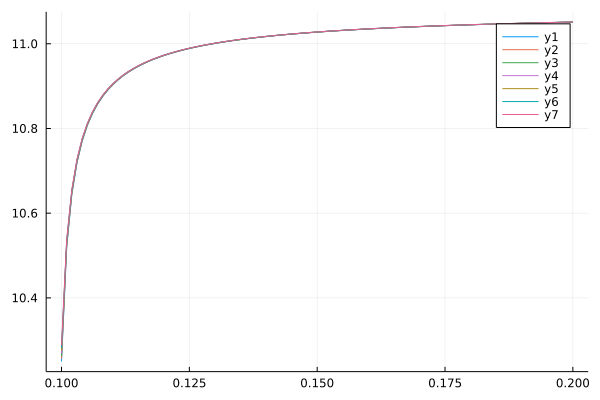

In [71]:
plot(k_grid, [V_store[1,:] V_store[2,:] V_store[3,:] V_store[4,:] V_store[5,:] V_store[6,:] V_store[7,:]])

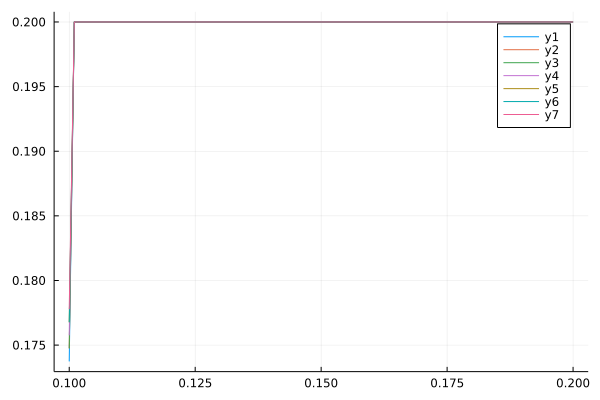

In [72]:
plot(k_grid, [k_grid[Int.(policy_index[1,:]),:] k_grid[Int.(policy_index[2,:]),:] k_grid[Int.(policy_index[3,:]),:] k_grid[Int.(policy_index[4,:]),:] k_grid[Int.(policy_index[5,:]),:] k_grid[Int.(policy_index[6,:]),:] k_grid[Int.(policy_index[7,:]),:]])

In [14]:
states_sim, states_idx_sim = mc_states(1, 1000, z_grid, k_grid, pi_matrix)

([0.9502491778486131 0.9665515056371354 … 1.0346060134072377 1.0171558451915015], [1.0 2.0 … 6.0 5.0])

In [379]:
function sim_var_data(tech_state, tech_index, T=1000)

    capital_path_index_sim = ones(T+1)
    
    # What we want
    assets_sim = zeros(T+1)
    labour_sim = zeros(T+1)
    prod_sim = zeros(T+1)
    cons_sim = zeros(T+1)
    inv_sim = zeros(T+1)
    
    # Find capital accumulation
    for t in 1:T
        # Find appropriate index of the policy function
        capital_path_index_sim[t+1] = policy_index[Int.(tech_index[t]), Int.(capital_path_index_sim[t])]
        # Find grid point associated with the grid
        assets_sim[t] = k_grid[Int.(capital_path_index_sim[t+1])]
        labour_sim[t] = nstar(tech_state[t], assets_sim[t])
        prod_sim[t] = prod(tech_state[t], assets_sim[t], labour_sim[t])
    end

    for t in 1:T
        cons_sim[t] = cons(tech_state[t], assets_sim[t], assets_sim[t+1], labour_sim[t])
        inv_sim[t] = prod_sim[t] - cons_sim[t]
    end
    
    return assets_sim, labour_sim, prod_sim, cons_sim, inv_sim
    
end

sim_var_data (generic function with 2 methods)

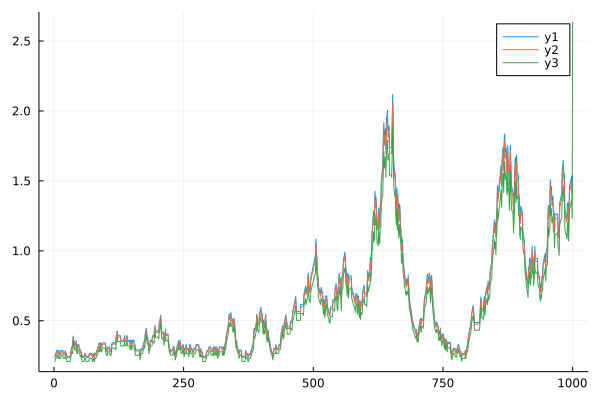

In [282]:
plot([labour_sim[1:end-1], prod_sim[1:end-1], cons_sim[1:end-1]])

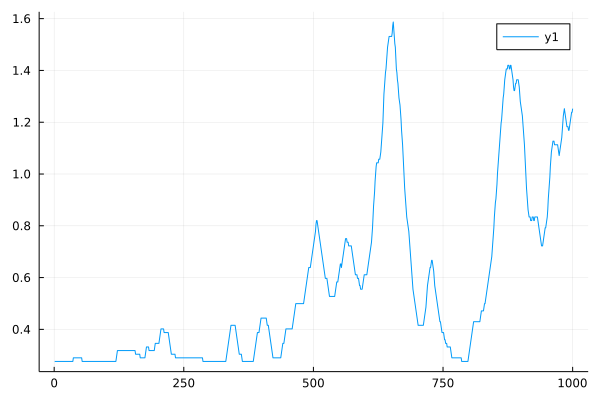

In [283]:
plot(assets_sim[1:end-1])

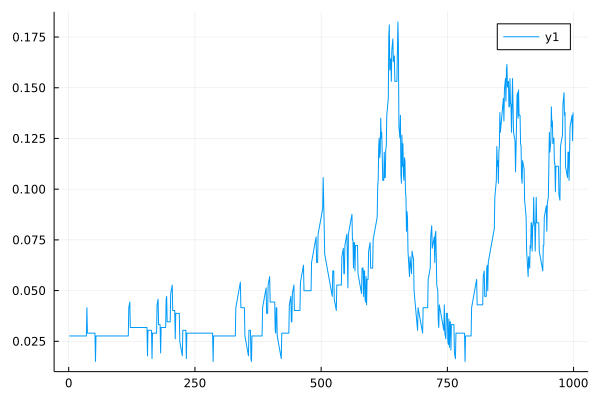

In [281]:
plot(inv_sim[1:end-2])

---
## Step 2

In [308]:
# Recover estimated rho_a and sigma_a
y_lag = zeros(T)
y_lag[2:end] = states_sim[1:end-1]
data = DataFrame(y = log.(states_sim[1,:])[2:end], x=log.(y_lag)[2:end])
lm(@formula(y ~ x), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.0002986  0.000350768  -0.85    0.3948  -0.000986928  0.000389729
x             0.914538   0.0127187    71.91    <1e-99   0.889579     0.939496
────────────────────────────────────────────────────────────────────────────────

Both are more or less accurately estimated by an AR(1)

In [328]:
# Recover n from optimal labour decision
n_step = zeros(T-1)
for t in 1:T-1
    n_step[t] = (assets_sim[t] / labour_sim[t]) .^ (1 - alpha) * states_sim[t] .* alpha
end

mean(n_step)

0.7800000000000005

---
## Step 3

In [400]:
# True moments

inv_lag = zeros(T)
inv_lag[2:end] = inv_sim[1:end-2]
output_lag = zeros(T)
output_lag[2:end] = prod_sim[1:end-2]

inv_lag_2 = zeros(T)
inv_lag_2[3:end] = inv_sim[1:end-3]
output_lag_2 = zeros(T)
output_lag_2[3:end] = prod_sim[1:end-3]

data_var = DataFrame(inv = inv_sim[1:end-1], inv_lag=inv_lag, inv_lag2 = inv_lag_2, output= prod_sim[1:end-1], 
    output_lag=output_lag, output_lag2=output_lag_2)

model_inv = lm(@formula(inv ~ inv_lag +inv_lag + inv_lag2 + output_lag + output_lag2), data_var)
inv_coef = coef(model_inv)[2:end]
inv_err = (data_var[:,1] - predict(model_inv))

model_out = lm(@formula(output ~ inv_lag +inv_lag + inv_lag2 + output_lag + output_lag2), data_var)
out_coef = coef(model_out)[2:end]
out_err = (data_var[:,4] - predict(model_out))

var_err_inv = var(inv_err)
var_err_out = var(out_err)
cov_err = cov(inv_err, out_err)

data_moments = vcat(inv_coef, out_coef, var_err_inv, var_err_out, cov_err)
data_moments

11-element Vector{Float64}:
  0.41045962616806486
  0.13972364907801793
  0.10346628561218364
 -0.07071915284971177
  6.556054463493584
 -3.4468442821665746
  0.6285968619467827
  0.0930257882145698
  0.0016129438279101006
  0.0006414258137005143
 -1.3263421674930353e-5

In [387]:
function data_prep(inv_sim, prod_sim, T=1000)
    
    inv_lag = zeros(T)
    inv_lag_2 = zeros(T)
    inv_lag[2:end] = inv_sim[1:end-2]
    inv_lag_2[3:end] = inv_sim[1:end-3]
    
    output_lag = zeros(T)
    output_lag[2:end] = prod_sim[1:end-2]
    output_lag_2 = zeros(T)
    output_lag_2[3:end] = prod_sim[1:end-3]
    
    data_var = DataFrame(inv = inv_sim[1:end-1], inv_lag=inv_lag, inv_lag2 = inv_lag_2, output= prod_sim[1:end-1], 
        output_lag=output_lag, output_lag2=output_lag_2)

    return data_var
end

data_prep (generic function with 3 methods)

In [397]:
function moments(data_var)
    
    model_inv = lm(@formula(inv ~ inv_lag +inv_lag + inv_lag2 + output_lag + output_lag2), data_var)
    inv_coef = coef(model_inv)[2:end]
    inv_err = (data_var[:,1] - predict(model_inv))

    model_out = lm(@formula(output ~ inv_lag +inv_lag + inv_lag2 + output_lag + output_lag2), data_var)
    out_coef = coef(model_out)[2:end]
    out_err = (data_var[:,4] - predict(model_out))

    var_err_inv = var(inv_err)
    var_err_out = var(out_err)
    cov_err = cov(inv_err, out_err)
    
    moments = vcat(inv_coef, out_coef, var_err_inv, var_err_out, cov_err)
    
    return moments
    
end

moments (generic function with 1 method)

In [408]:
function criterion(sim_moments, data_moments, W)
    
    criterion = ((sim_moments - data_moments)' * W * (sim_moments - data_moments))[1]

    return criterion
    
end

criterion (generic function with 1 method)

In [459]:
# formulate a grid around the two leftover parameters gamma and beta

@time begin
Random.seed!(1234)    
beta_grid = LinRange(0.2, 1, 30)
gamma_grid = LinRange(0.5, 5, 30)
total_comb = length(beta_grid)*length(gamma_grid)
dist = zeros(length(beta_grid)*length(gamma_grid), 3)
dist[:,1] = repeat(beta_grid, length(gamma_grid))
dist[:,2] = repeat(beta_grid, length(gamma_grid))

iter = 1
for i in 1:length(beta_grid)
    beta_now = beta_grid[i]
    println("We are at $i / ")
    
    for j in 1:length(gamma_grid)
        gamma_now = gamma_grid[j]
        println("We are at $j / ")
        
        labour_store_var, util_store_var = labour_decision(k_grid, z_grid, gamma_now)
        V_store_var, policy_index_var, iter_var = value_fun_it(beta_now, k_grid, z_grid, pi_matrix, util_store)
        states_sim_var, states_idx_sim_var = mc_states(1, 1000, z_grid, k_grid, pi_matrix)
        assets_sim_var, labour_sim_var, prod_sim_var, cons_sim_var, inv_sim_var = sim_var_data(states_sim_var, states_idx_sim_var)
        
        data_var_grid = data_prep(inv_sim_var, prod_sim_var)
        sim_moments = moments(data_var_grid)
        
        dist[iter,3] = criterion(sim_moments, data_moments, Matrix(1.0I, length(sim_moments), length(sim_moments)))
        println(dist[iter,3])
        iter = iter +1
            
    end
end
    
end

We are at 1 / 
We are at 1 / 
1.1590313010273028
We are at 2 / 
6.612008220931481
We are at 3 / 
4.376474379389128
We are at 4 / 
2.2314915972596756
We are at 5 / 
3.249223372096765
We are at 6 / 
9.077980149985674
We are at 7 / 
1.404786314201747
We are at 8 / 
3.0856759178342306
We are at 9 / 
4.870127864521607
We are at 10 / 
4.2380054860265375
We are at 11 / 
0.4902426301500337
We are at 12 / 
4.238601111865994
We are at 13 / 
0.5442175516350691
We are at 14 / 
1.9796008329209336
We are at 15 / 
1.6018397415898555
We are at 16 / 
1.8774848889584523
We are at 17 / 
8.5998070626077
We are at 18 / 
0.41152833299511427
We are at 19 / 
2.729006915866215
We are at 20 / 
8.802884755157363
We are at 21 / 
2.0821830975424342
We are at 22 / 
2.36358830926436
We are at 23 / 
0.6332157582394702
We are at 24 / 
0.9925981027737841
We are at 25 / 
7.486948214368281
We are at 26 / 
0.9121139141254958
We are at 27 / 
1.6797316217960199
We are at 28 / 
3.6871174796705075
We are at 29 / 
3.2416571602

In [460]:
min_idx = argmin(dist[:,3])

dist[min_idx,:]

3-element Vector{Float64}:
 0.4482758620689655
 0.4482758620689655
 0.052566756873500646

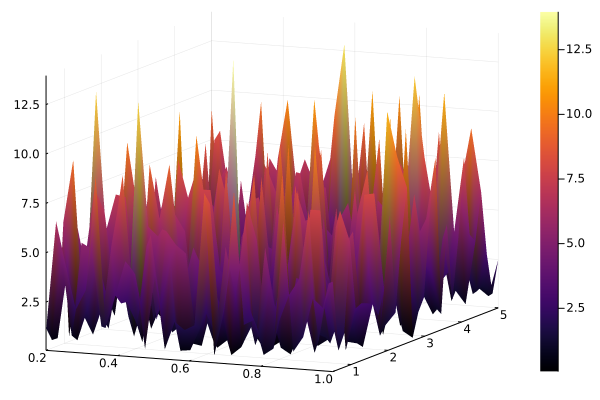

In [461]:
surface(beta_grid, gamma_grid, dist[:,3])

In [450]:
plot(beta_grid, dist[1,:,3])

LoadError: BoundsError: attempt to access 900×3 Matrix{Float64} at index [1, 1:3, 3]

In [ ]:
# Given the true parameters the SMM seems to be a good fit for beta. Gamma seems quite far off.